In [1]:
import my_modules.monte_carlo as mc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

C:\Users\jdivers\PycharmProjects\df_image_analysis\.venv\Lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [2]:
dw = mc.OpticalMedium(n=1.33, mu_a=0, mu_s=0, name='water', display_color='aqua')
g = mc.OpticalMedium(n=1.523, mu_a=0, mu_s=0, name='glass', display_color='gray')
t = mc.OpticalMedium(n=1.33, mu_a=5, mu_s=10, g=0.9, name='tissue', display_color='lightpink')
surroundings_n = 1.33

OD = 0.3205672345588178
ID = 0.27206723455881785
theta = np.arctan(-OD / 0.2)

sampler = mc.monte_carlo.ring_pattern((ID, OD), theta)
LED = mc.Illumination(pattern=sampler)
detector = mc.Detector(mc.monte_carlo.cone_of_acceptance(ID))

n = 250

C:\Users\jdivers\PycharmProjects\df_image_analysis\my_modules\monte_carlo\monte_carlo.py:101: UserWarning: g is automatically set to 1 where mu_s is 0. Set a non-zero scattering coefficient if a non-unity g value is necessary.
  warnings.warn('g is automatically set to 1 where mu_s is 0. '


# Simulation comparisons
| ID | System               | Tissue thickness | Simulation method | Recursion | Illumination direction | Illumination Incidence | Detector   | Comparison | Notes                                        |
|:---|:---------------------|:-----------------|:------------------|:----------|:-----------------------|:-----------------------|:-----------|:-----------|:---------------------------------------------|
| 1  | Tissue               | Inf              | Manual Method     | False     | Normal                 | Origin                 | None       | A          |                                              |
| 2  | Tissue               | Inf              | Photon Method     | False     | Normal                 | Origin                 | None       | AB         |                                              |
| 3  | Tissue               | Inf              | Photon Method     | Simple    | Normal                 | Origin                 | None       | BC         |                                              |
| 4  | Tissue               | Inf              | Photon Method     | Simple    | Oblique                | Origin                 | None       | CD         | Compared direciton sampling in sub-a and -b  |
| 5  | Tissue               | Inf              | Photon Method     | Simple    | Oblique                | Ring                   | None       | DE         | Compared location sampline in sub-a and -b   |
| 6  | Tissue               | Inf              | Photon Method     | Simple    | Oblique                | Ring                   | Inner cone | EF         | Compare detection accounting in sub-a and -b |
| 7  | Water, Tissue        | Inf              | Photon Method     | Simple    | Oblique                | Ring                   | Inner cone | FG         |                                              |
| 8  | Water, Glass, Tissue | Inf              | Photon Method     | Simple    | Oblique                | Ring                   | Inner cone | GH         |                                              |
| 9  | Water, Glass, Tissue | 1mm              | Photon Method     | Simple    | Oblique                | Ring                   | Inner cone | GH         |                                              |


## Simulation 1

In [3]:
s = mc.System(
    t, float('inf'),
    surrounding_n=surroundings_n,
    illuminator=LED,
    detector=(detector, 0),
)
print(s)

 __________________ 
|------ -inf ------|
|-> Surroundings <-|
|------- 0 --------|
|->    Tissue    <-|
|------ inf -------|
 __________________ 


C:\Users\jdivers\PycharmProjects\df_image_analysis\my_modules\monte_carlo\monte_carlo.py:602: RuntimeWarning: divide by zero encountered in divide
  step = np.where(mu_t > 0, -np.log(np.random.rand(self.batch_size)) / mu_t, float('inf'))


0 total internal reflectance events.
0.00% of photons transmitted. 
0.84% of photons reflected 
99.07% of photons absorbed 
250 total photons simulated.
0.09% overage of photons.


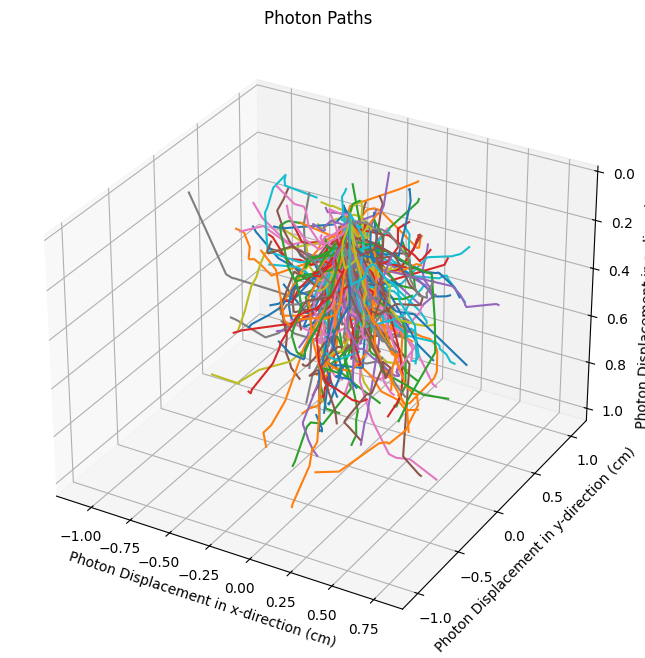

In [4]:
photon = mc.Photon(650, n=n, system=s, recurse=False, russian_roulette_constant=20)
while not photon.is_terminated:
    photon.absorb()
    photon.move()
    photon.scatter()
photon.plot_path()

print("{}".format(np.sum(photon.tir_count)) + ' total internal reflectance events.')
print("{:.2f}".format(photon.T / n * 100) + '% of photons transmitted. ')
print("{:.2f}".format(photon.R / n * 100) + '% of photons reflected ')
print("{:.2f}".format(photon.A / n * 100) + '% of photons absorbed ')
print("{:.0f}".format(sum([photon.T, photon.R, photon.A])) + ' total photons simulated.')
print("{:0.2f}% overage of photons.".format(100 * (n - sum([photon.T, photon.R, photon.A])) / n))

## Simulation 2

Using `photon.simulate()` method

0 total internal reflectance events.
0.00% of photons transmitted. 
0.43% of photons reflected 
99.58% of photons absorbed 
250 total photons simulated.
-0.01% overage of photons.


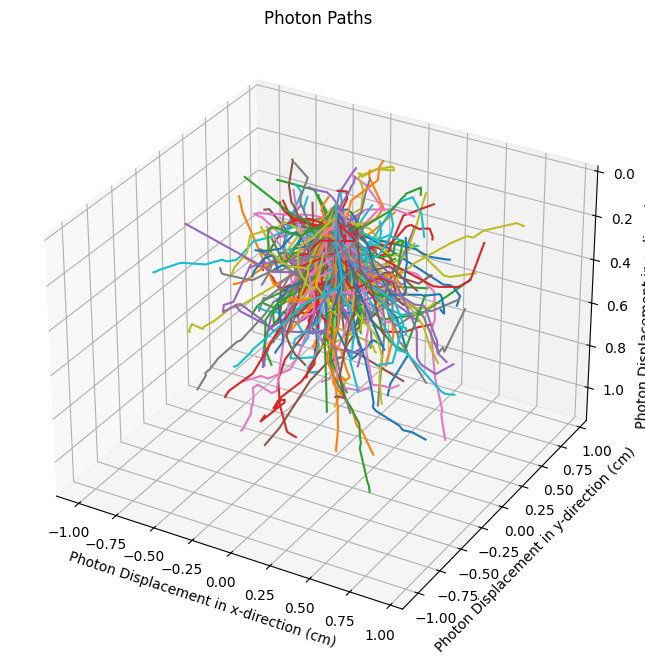

In [5]:
photon = mc.Photon(650, n=n, system=s, recurse=False, russian_roulette_constant=20)
photon.simulate()
photon.plot_path()
print("{}".format(np.sum(photon.tir_count)) + ' total internal reflectance events.')
print("{:.2f}".format(photon.T / n * 100) + '% of photons transmitted. ')
print("{:.2f}".format(photon.R / n * 100) + '% of photons reflected ')
print("{:.2f}".format(photon.A / n * 100) + '% of photons absorbed ')
print("{:.0f}".format(sum([photon.T, photon.R, photon.A])) + ' total photons simulated.')
print("{:0.2f}% overage of photons.".format(100 * (n - sum([photon.T, photon.R, photon.A])) / n))

## Simulation 3

Using recursion

0 total internal reflectance events.
0.00% of photons transmitted. 
1.89% of photons reflected 
198.40% of photons absorbed 
501 total photons simulated.
-100.29% overage of photons.


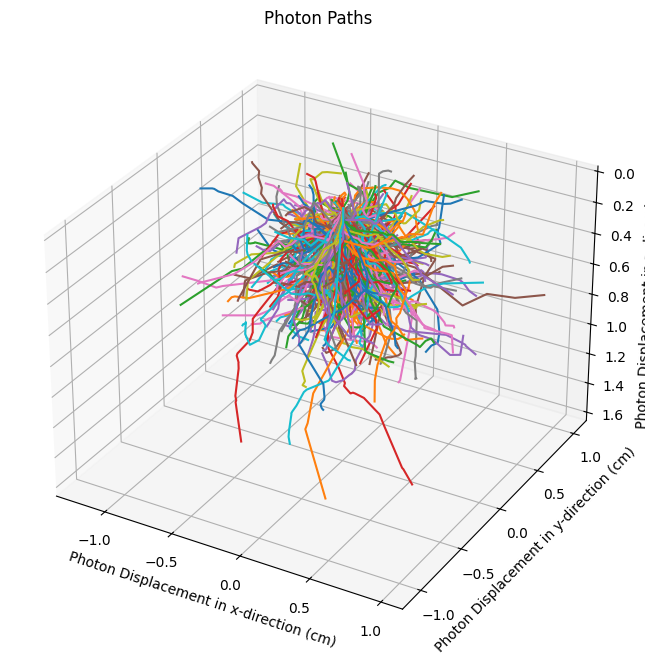

In [6]:
photon = mc.Photon(650, n=500, system=s, recurse=True, russian_roulette_constant=20)
photon.simulate()
photon.plot_path()
print("{}".format(np.sum(photon.tir_count)) + ' total internal reflectance events.')
print("{:.2f}".format(photon.T / n * 100) + '% of photons transmitted. ')
print("{:.2f}".format(photon.R / n * 100) + '% of photons reflected ')
print("{:.2f}".format(photon.A / n * 100) + '% of photons absorbed ')
print("{:.0f}".format(sum([photon.T, photon.R, photon.A])) + ' total photons simulated.')
print("{:0.2f}% overage of photons.".format(100 * (n - sum([photon.T, photon.R, photon.A])) / n))

## Simulation 4

Using angular incidence

### 4a

Angle set directly.

0 total internal reflectance events.
0.00% of photons transmitted. 
4.00% of photons reflected 
95.93% of photons absorbed 
250 total photons simulated.
0.07% overage of photons.


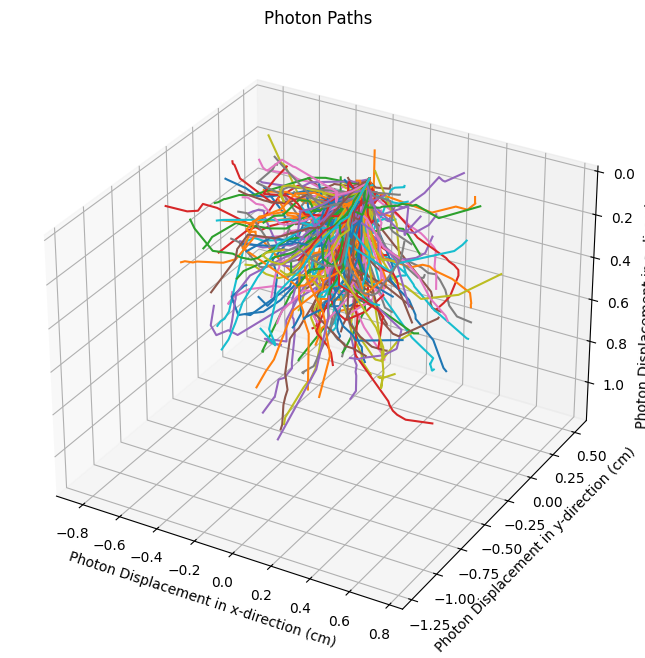

In [7]:
phi = 2 * np.pi * np.random.rand()
dir_cos = np.array([np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)])
photon = mc.Photon(650, n=n, directional_cosines=dir_cos, system=s, recurse=True, russian_roulette_constant=20)
photon.simulate()
photon.plot_path()
print("{}".format(np.sum(photon.tir_count)) + ' total internal reflectance events.')
print("{:.2f}".format(photon.T / n * 100) + '% of photons transmitted. ')
print("{:.2f}".format(photon.R / n * 100) + '% of photons reflected ')
print("{:.2f}".format(photon.A / n * 100) + '% of photons absorbed ')
print("{:.0f}".format(sum([photon.T, photon.R, photon.A])) + ' total photons simulated.')
print("{:0.2f}% overage of photons.".format(100 * (n - sum([photon.T, photon.R, photon.A])) / n))

### 4b

Angle sampled from `sampler()`

0 total internal reflectance events.
0.00% of photons transmitted. 
4.75% of photons reflected 
95.16% of photons absorbed 
250 total photons simulated.
0.09% overage of photons.


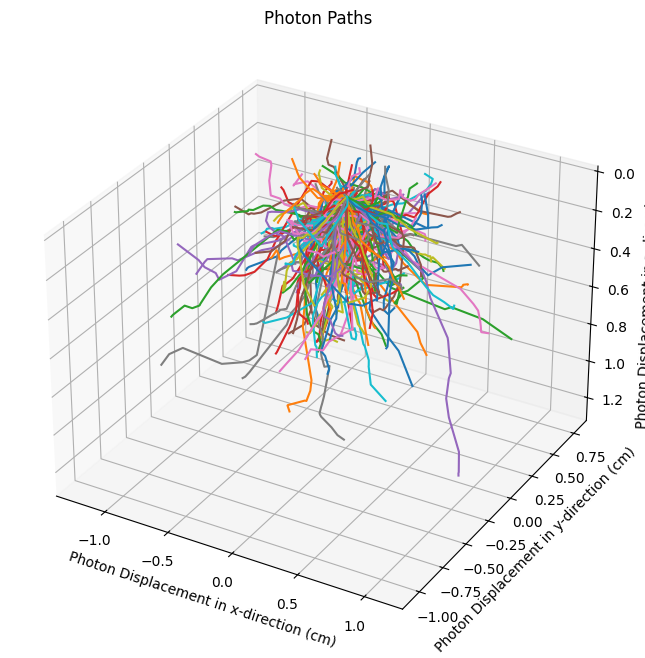

In [8]:
_, direction = sampler(n)
photon = mc.Photon(650, n=n, directional_cosines=direction, system=s, recurse=True, russian_roulette_constant=20)
photon.simulate()
photon.plot_path()
print("{}".format(np.sum(photon.tir_count)) + ' total internal reflectance events.')
print("{:.2f}".format(photon.T / n * 100) + '% of photons transmitted. ')
print("{:.2f}".format(photon.R / n * 100) + '% of photons reflected ')
print("{:.2f}".format(photon.A / n * 100) + '% of photons absorbed ')
print("{:.0f}".format(sum([photon.T, photon.R, photon.A])) + ' total photons simulated.')
print("{:0.2f}% overage of photons.".format(100 * (n - sum([photon.T, photon.R, photon.A])) / n))

## Simulation 5

Using location distribution

### 5a

location from `sampler()`

0 total internal reflectance events.
0.00% of photons transmitted. 
4.30% of photons reflected 
95.63% of photons absorbed 
250 total photons simulated.
0.07% overage of photons.


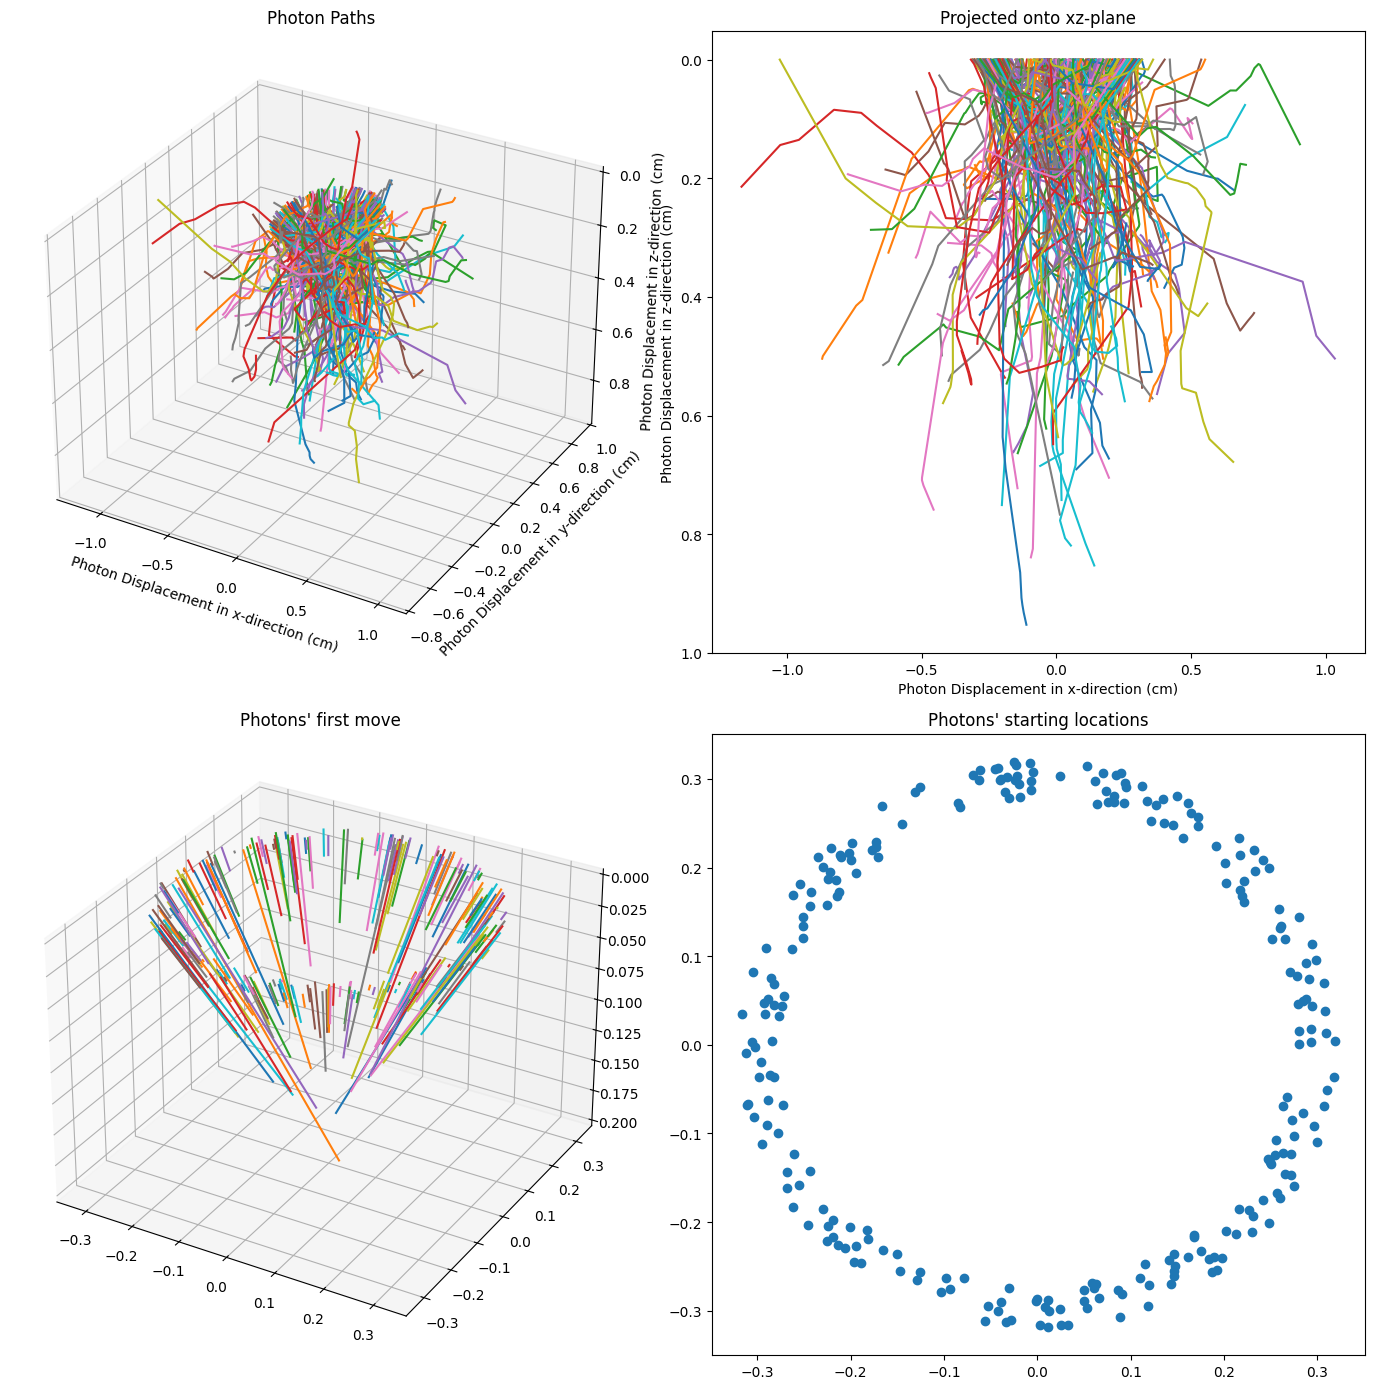

In [9]:
fig = plt.figure(figsize=(14, 14))
ax = np.array([
    fig.add_subplot(2, 2, 1, projection='3d'), fig.add_subplot(2, 2, 2),
    fig.add_subplot(2, 2, 3, projection='3d'), fig.add_subplot(2, 2, 4)
])

location, direction = sampler(n)
photon = mc.Photon(650, n=n, location_coordinates=location, directional_cosines=direction, system=s, recurse=True, russian_roulette_constant=20)
photon.simulate()

photon.plot_path(axes=ax[0])
photon.plot_path(project_onto='xz', axes=[ax[1]])
x,y,z = [photon.location_history[: , i, :2] for i in range(3)]
for i in range(n):
    ax[2].plot(x[i],y[i],z[i])
ax[3].scatter(*photon.location_history[:, :2, 0].T)
ax[2].set_title("Photons' first move")
ax[2].invert_zaxis()
ax[3].set_title("Photons' starting locations")
fig.tight_layout()
print("{}".format(np.sum(photon.tir_count)) + ' total internal reflectance events.')
print("{:.2f}".format(photon.T / n * 100) + '% of photons transmitted. ')
print("{:.2f}".format(photon.R / n * 100) + '% of photons reflected ')
print("{:.2f}".format(photon.A / n * 100) + '% of photons absorbed ')
print("{:.0f}".format(sum([photon.T, photon.R, photon.A])) + ' total photons simulated.')
print("{:0.2f}% overage of photons.".format(100 * (n - sum([photon.T, photon.R, photon.A])) / n))

### 5b

location and direction from `system.beam()` 

0 total internal reflectance events.
0.00% of photons transmitted. 
3.83% of photons reflected 
96.28% of photons absorbed 
250 total photons simulated.
-0.11% overage of photons.


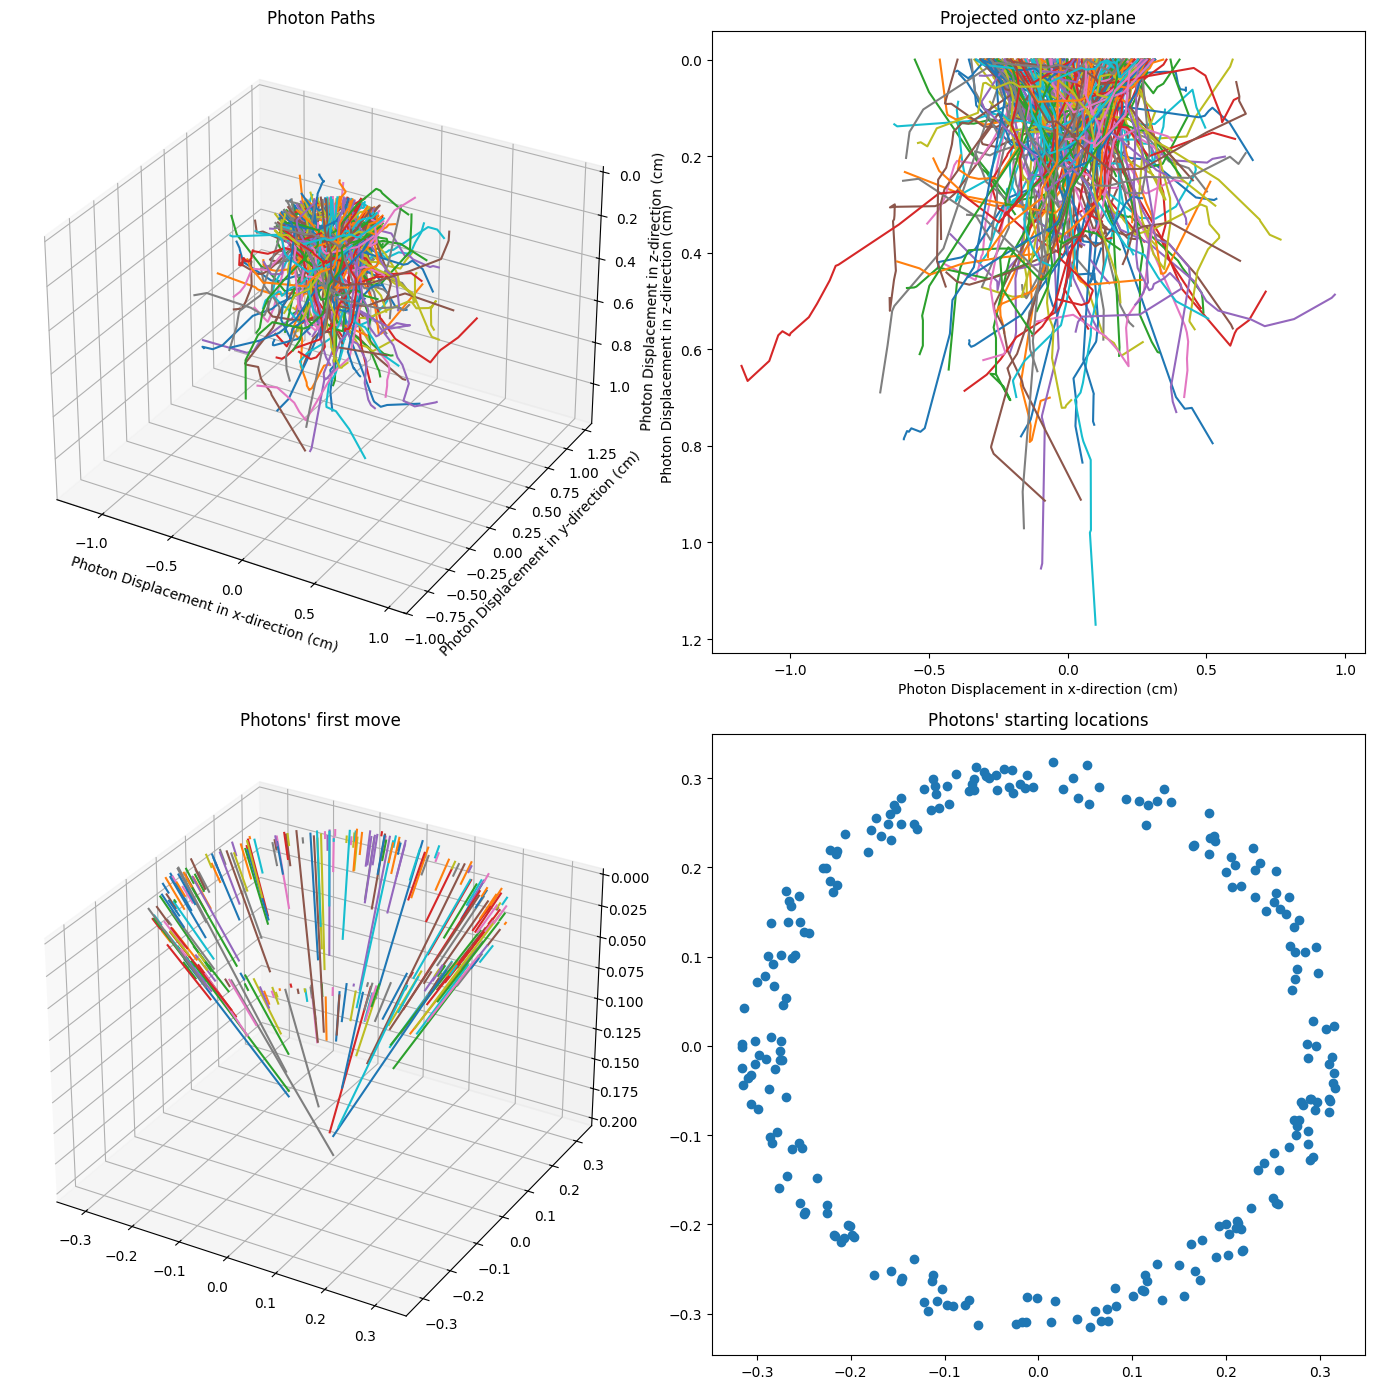

In [10]:
fig = plt.figure(figsize=(14, 14))
ax = np.array([
    fig.add_subplot(2, 2, 1, projection='3d'), fig.add_subplot(2, 2, 2), 
    fig.add_subplot(2, 2, 3, projection='3d'), fig.add_subplot(2, 2, 4)
])
photon = s.beam(n=n, recurse=True, russian_roulette_constant=20)
photon.simulate()

photon.plot_path(axes=ax[0])
photon.plot_path(project_onto='xz', axes=[ax[1]])
x,y,z = [photon.location_history[: , i, :2] for i in range(3)]
for i in range(n):
    ax[2].plot(x[i],y[i],z[i])
ax[3].scatter(*photon.location_history[:, :2, 0].T)
ax[2].set_title("Photons' first move")
ax[2].invert_zaxis()
ax[3].set_title("Photons' starting locations")
fig.tight_layout()
print("{}".format(np.sum(photon.tir_count)) + ' total internal reflectance events.')
print("{:.2f}".format(photon.T / n * 100) + '% of photons transmitted. ')
print("{:.2f}".format(photon.R / n * 100) + '% of photons reflected ')
print("{:.2f}".format(photon.A / n * 100) + '% of photons absorbed ')
print("{:.0f}".format(sum([photon.T, photon.R, photon.A])) + ' total photons simulated.')
print("{:0.2f}% overage of photons.".format(100 * (n - sum([photon.T, photon.R, photon.A])) / n))

## Simulation 6

Using detection region

### 6a

Manually testing for detection

0 total internal reflectance events.
0.00% of photons transmitted. 
4.25% of photons reflected 
95.75% of photons absorbed 
250 total photons simulated.
3.72% of photons detected 
-0.00% overage of photons.


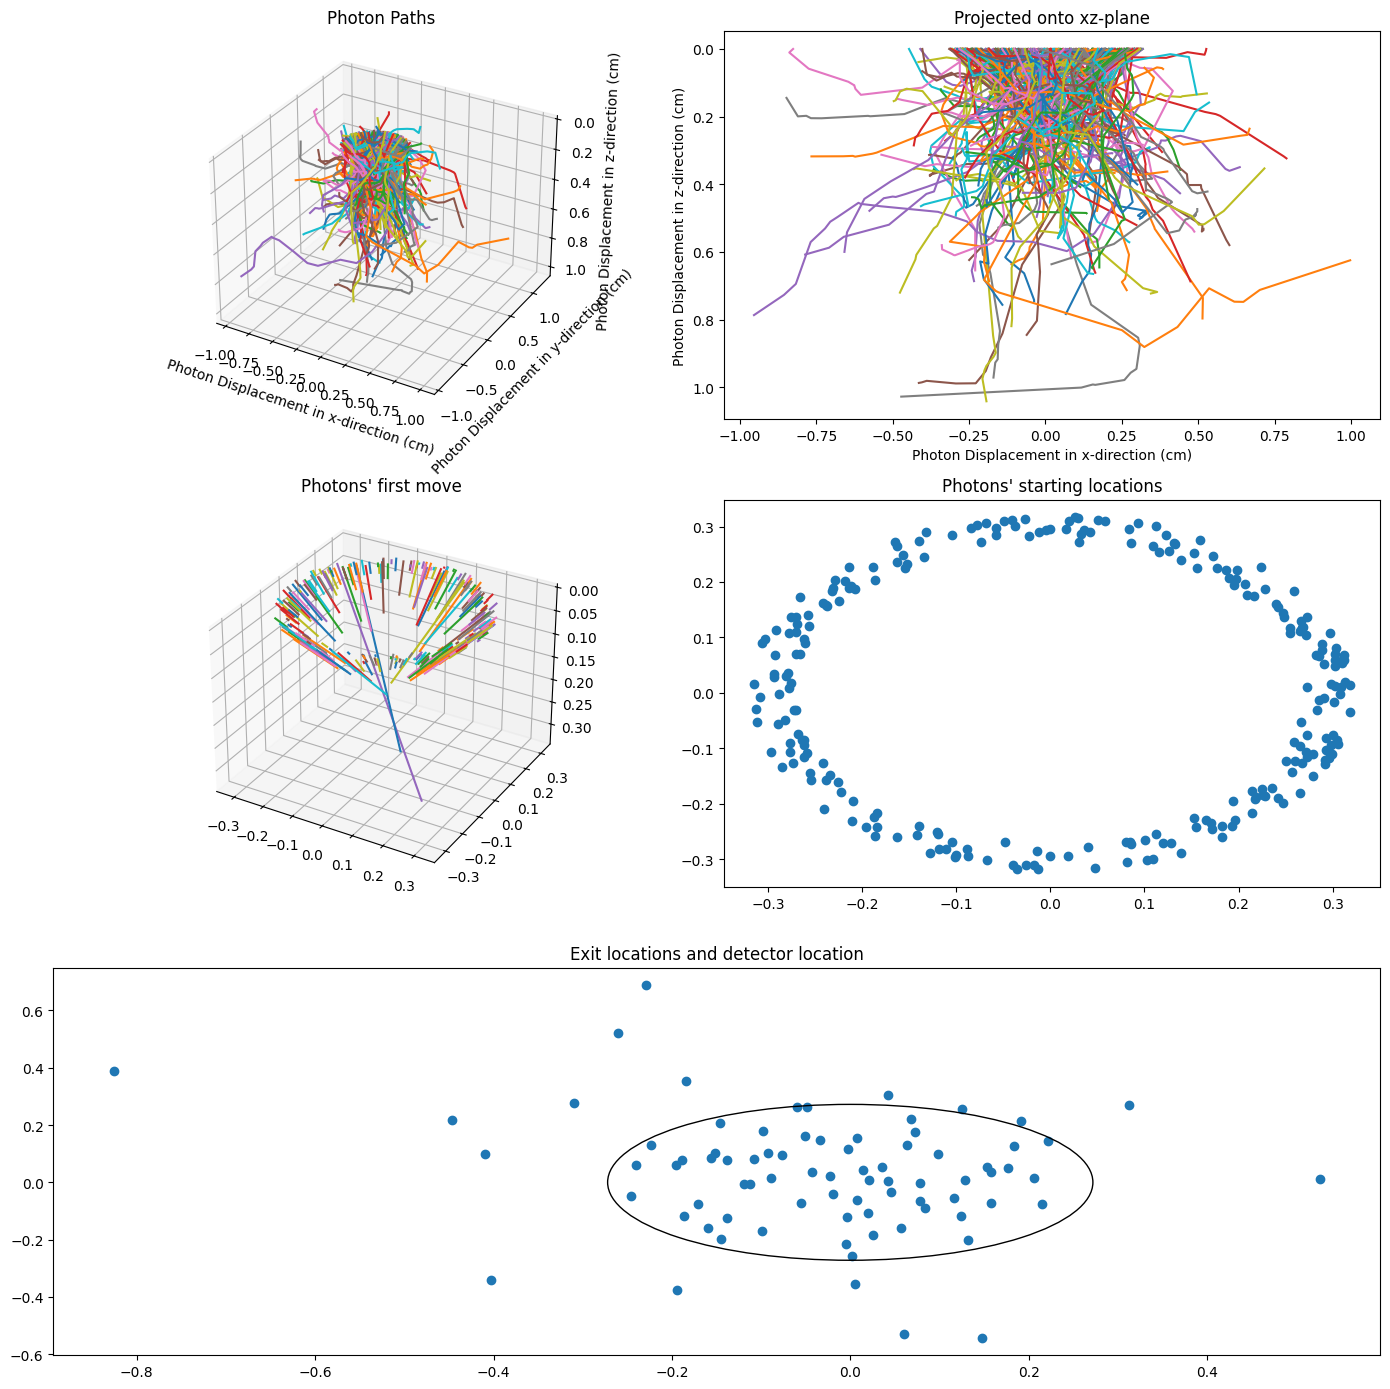

In [11]:
detected = 0
fig = plt.figure(figsize=(14, 14))
ax = np.array([
    fig.add_subplot(3, 2, 1, projection='3d'), fig.add_subplot(3, 2, 2), 
    fig.add_subplot(3, 2, 3, projection='3d'), fig.add_subplot(3, 2, 4),
    fig.add_subplot(3, 1, 3)
])
photon = s.beam(n=n, recurse=True, russian_roulette_constant=20)
photon.simulate()
exit_r = np.sqrt(photon.exit_location[:, 0] ** 2 + photon.exit_location[:, 1] ** 2)  if photon.exit_location is not None else float('inf')
detected += np.sum(np.where(exit_r < ID, photon.exit_weight, 0))

photon.plot_path(axes=ax[0])
photon.plot_path(project_onto='xz', axes=[ax[1]])
x,y,z = [photon.location_history[: , i, :2] for i in range(3)]
for i in range(n):
    ax[2].plot(x[i],y[i],z[i])
ax[3].scatter(*photon.location_history[:, :2, 0].T)
x,y,_ = photon.exit_location.T if photon.exit_location is not None else [(), (), ()]
ax[4].scatter(x,y)
ax[2].set_title("Photons' first move")
ax[2].invert_zaxis()
ax[3].set_title("Photons' starting locations")
detector_circle = patches.Circle((0,0), ID, edgecolor='black', facecolor='none')
ax[4].add_patch(detector_circle)
ax[4].set_title('Exit locations and detector location')
fig.tight_layout()
print("{}".format(np.sum(photon.tir_count)) + ' total internal reflectance events.')
print("{:.2f}".format(photon.T / n * 100) + '% of photons transmitted. ')
print("{:.2f}".format(photon.R / n * 100) + '% of photons reflected ')
print("{:.2f}".format(photon.A / n * 100) + '% of photons absorbed ')
print("{:.0f}".format(sum([photon.T, photon.R, photon.A])) + ' total photons simulated.')
print("{:.2f}".format(detected / n * 100) + '% of photons detected ')
print("{:0.2f}% overage of photons.".format(100 * (n - sum([photon.T, photon.R, photon.A])) / n))

### 6b
Built-in detector method

0 total internal reflectance events.
0.00% of photons transmitted. 
4.17% of photons reflected 
95.86% of photons absorbed 
250 total photons simulated.
3.27% of photons detected 
-0.02% overage of photons.


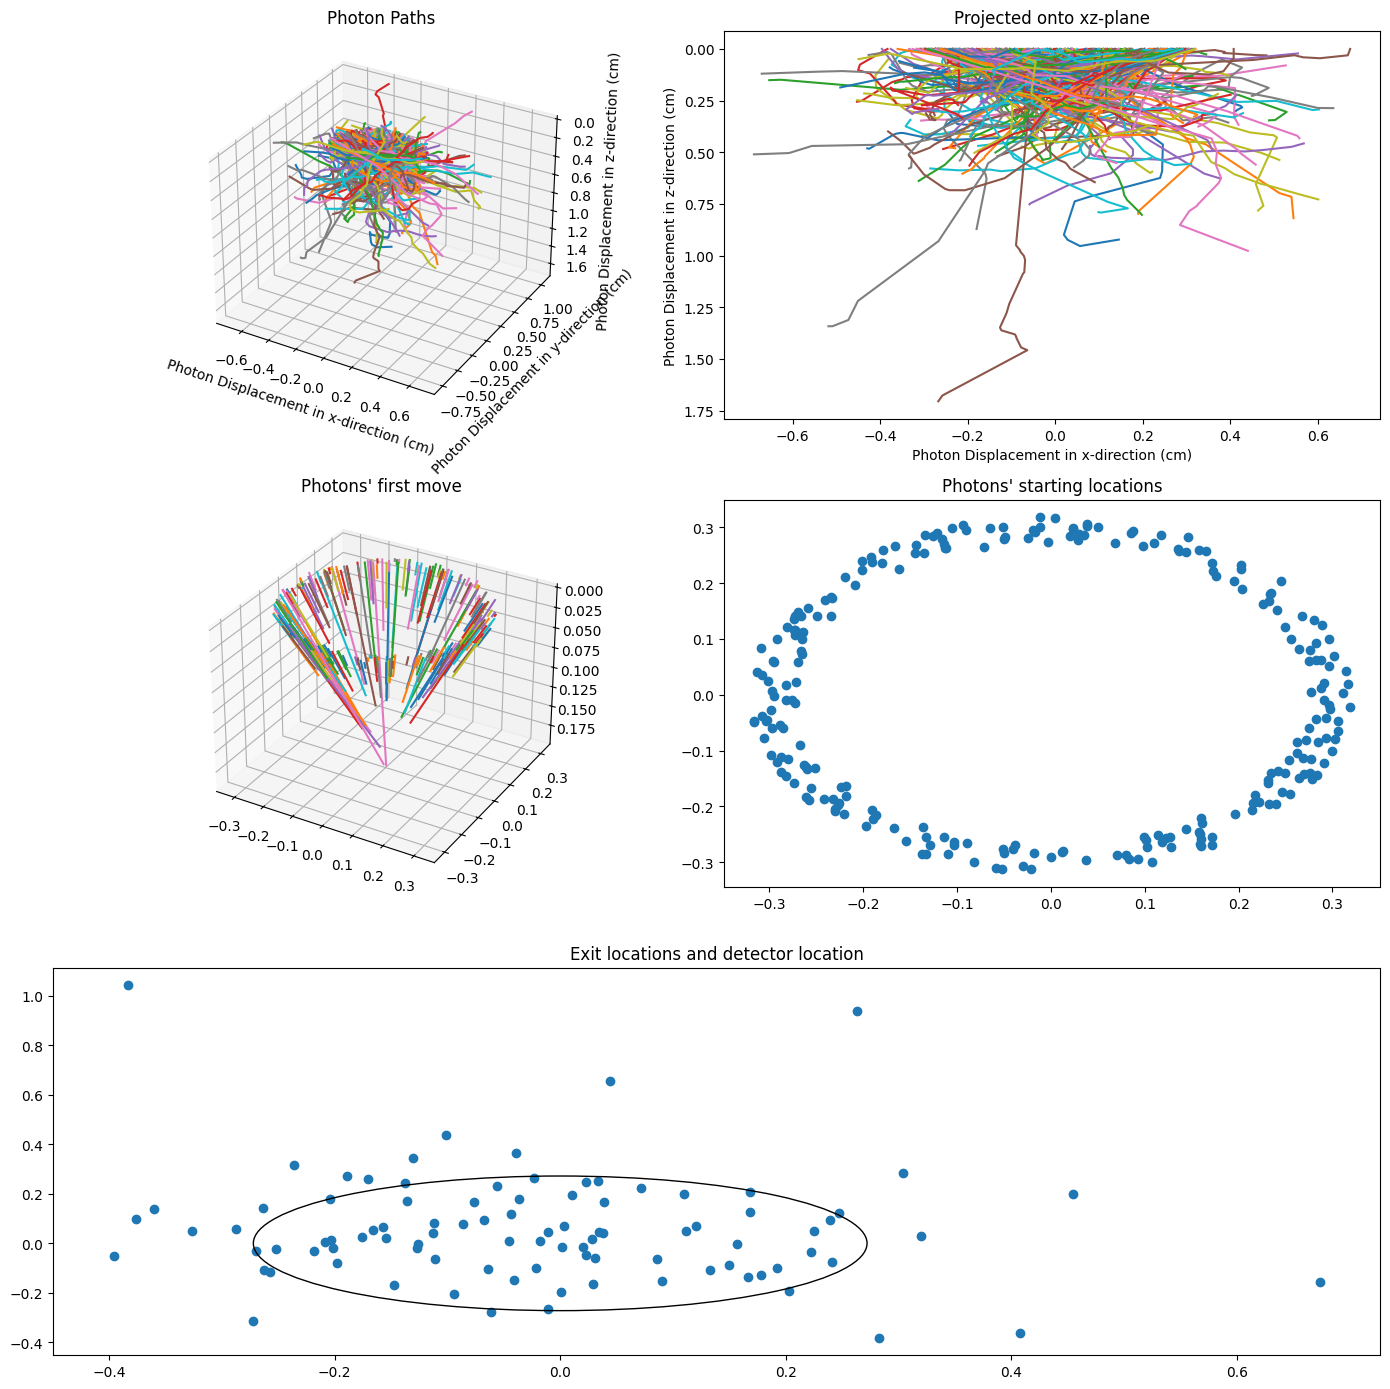

In [12]:
detector.reset()
fig = plt.figure(figsize=(14, 14))
ax = np.array([
    fig.add_subplot(3, 2, 1, projection='3d'), fig.add_subplot(3, 2, 2), 
    fig.add_subplot(3, 2, 3, projection='3d'), fig.add_subplot(3, 2, 4),
    fig.add_subplot(3, 1, 3)
])

photon = s.beam(n=n, recurse=True, russian_roulette_constant=20)
photon.simulate()

photon.plot_path(axes=ax[0])
photon.plot_path(project_onto='xz', axes=[ax[1]])
x,y,z = [photon.location_history[: , i, :2] for i in range(3)]
for i in range(n):
    ax[2].plot(x[i],y[i],z[i])
ax[3].scatter(*photon.location_history[:, :2, 0].T)
x,y,_ = photon.exit_location.T if photon.exit_location is not None else [(), (), ()]
ax[4].scatter(x,y)
ax[2].set_title("Photons' first move")
ax[2].invert_zaxis()
ax[3].set_title("Photons' starting locations")
detector_circle = patches.Circle((0,0), ID, edgecolor='black', facecolor='none')
ax[4].add_patch(detector_circle)
ax[4].set_title('Exit locations and detector location')
fig.tight_layout()
print("{}".format(np.sum(photon.tir_count)) + ' total internal reflectance events.')
print("{:.2f}".format(photon.T / n * 100) + '% of photons transmitted. ')
print("{:.2f}".format(photon.R / n * 100) + '% of photons reflected ')
print("{:.2f}".format(photon.A / n * 100) + '% of photons absorbed ')
print("{:.0f}".format(sum([photon.T, photon.R, photon.A])) + ' total photons simulated.')
print("{:.2f}".format(detector.n_detected / n * 100) + '% of photons detected ')
print("{:0.2f}% overage of photons.".format(100 * (n - sum([photon.T, photon.R, photon.A])) / n))

In [41]:
def make_all_plots(photon, tissue_start=0.2, into_tissue_step=1):
    fig = plt.figure(figsize=(14, 17.5))
    ax = np.array([
        fig.add_subplot(3, 4, 1, projection='3d'), fig.add_subplot(3, 4, 2), fig.add_subplot(3, 4, 3), fig.add_subplot(3, 4, 4),  # 0-3: Paths
        fig.add_subplot(3, 2, 3, projection='3d'), fig.add_subplot(3, 2, 4, projection='3d'),  # 4-5: Illumination pattern (beam in water and beam into tissue)
        fig.add_subplot(3, 2, 5), fig.add_subplot(3, 2, 6)  # 6-7: Incidence/detection at tissue and locations at objective
    ])
    
    photon.plot_path(axes=ax[0])
    photon.plot_path(project_onto='xy', axes=[ax[1]])
    photon.plot_path(project_onto='xz', axes=[ax[2]])
    photon.plot_path(project_onto='yz', axes=[ax[3]])
    
    # First move
    x,y,z = [photon.location_history[: , i, 0:2] for i in range(3)]
    for i in range(n):
        ax[4].plot(x[i],y[i],z[i])
    
    # Second move
    x,y,z = [photon.location_history[: , i, 1:3] for i in range(3)]
    for i in range(n):
        ax[5].plot(x[i],y[i],z[i])
    
    # Tissue positions
    # Starting point
    ax[6].scatter(*photon.location_history[:, :2, 1].T, color='b', label='Incident locations')
    # Exit locations
    out_of_tissue = photon.location_history[:,2] == tissue_start
    out_of_tissue[:, into_tissue_step] = False  # Ignore entry case
    x, y = np.where(out_of_tissue, [photon.location_history[:, 0], photon.location_history[:, 1]], np.nan)
    ax[6].scatter(x,y, color='r', label='Exit locations')
    
    # Objective positions
    # Starting point
    ax[7].scatter(*photon.location_history[:, :2, 0].T, color='b', label='Starting locations')
    # Exit location
    x,y,_ = photon.exit_location.T if photon.exit_location is not None else [(), (), ()]
    ax[7].scatter(x,y, color='r', label='Exit locations')
    
    ax[0].set(xlim=[-0.5, 0.5], ylim=[-0.5, 0.5], zlim=[0.4, -0.01])
    ax[1].set(xlim=[-0.5, 0.5], ylim=[-0.5, 0.5])
    ax[2].set(xlim=[-0.5, 0.5], ylim=[0.8, -0.01])
    s.represent_on_axis(ax=ax[2])
    ax[3].set(xlim=[-0.5, 0.5], ylim=[0.8, -0.010])
    s.represent_on_axis(ax=ax[3])
    ax[4].set(xlim=[-0.5, 0.5], ylim=[-0.5, 0.5], zlim=[0, 0.22])
    ax[4].set_title("Photons' move to tissue")
    ax[4].invert_zaxis()
    ax[5].set(xlim=[-0.2, 0.2], ylim=[-0.2, 0.2], zlim=[0.42, 0.2])
    ax[5].set_title("Photons' first step into tissue")
    ax[6].set(xlim=[-0.05, 0.05], ylim=[-0.05, 0.05])
    ax[6].set_title("Photons' incident and detection locations at tissue interface")
    ax[6].legend()
    ax[7].set(xlim=[-0.5, 0.5], ylim=[-.5, 0.5])
    ax[7].set_title("Photons' incident and detection locations at objective")
    detector_circle = patches.Circle((0, 0), ID, edgecolor='black', facecolor='none', label='Detector region')
    ax[7].add_patch(detector_circle)
    ax[7].set_title('Incident and Exit locations')
    ax[7].legend()
    fig.tight_layout()
    print("{}".format(np.sum(photon.tir_count)) + ' total internal reflectance events.')
    print("{:.2f}".format(photon.T / n * 100) + '% of photons transmitted. ')
    print("{:.2f}".format(photon.R / n * 100) + '% of photons reflected ')
    print("{:.2f}".format(photon.A / n * 100) + '% of photons absorbed ')
    print("{:.0f}".format(sum([photon.T, photon.R, photon.A])) + ' total photons simulated.')
    print("{:.2f}".format((photon.R - detector.n_detected)) + ' photons rejected by detector aperture.')
    print("{:.2f}".format(detector.n_detected / (n - (photon.R - detector.n_detected))  * 100) + '% of photons detected ')
    print("{:0.2f}% overage of photons.".format(100 * (n - sum([photon.T, photon.R, photon.A])) / n))

## Simulation 7
Using system with water layer

In [42]:
s = mc.System(
    dw, 0.2,
    t, float('inf'),
    surrounding_n=surroundings_n,
    illuminator=LED,
    detector=(detector,0)
)
print(s)

 __________________ 
|------ -inf ------|
|-> Surroundings <-|
|------- 0 --------|
|->    Water     <-|
|------ 0.2 -------|
|->    Tissue    <-|
|------ inf -------|
 __________________ 


0 total internal reflectance events.
0.00% of photons transmitted. 
3.69% of photons reflected 
96.35% of photons absorbed 
250 total photons simulated.
7.78 photons rejected by detector aperture.
0.60% of photons detected 
-0.04% overage of photons.


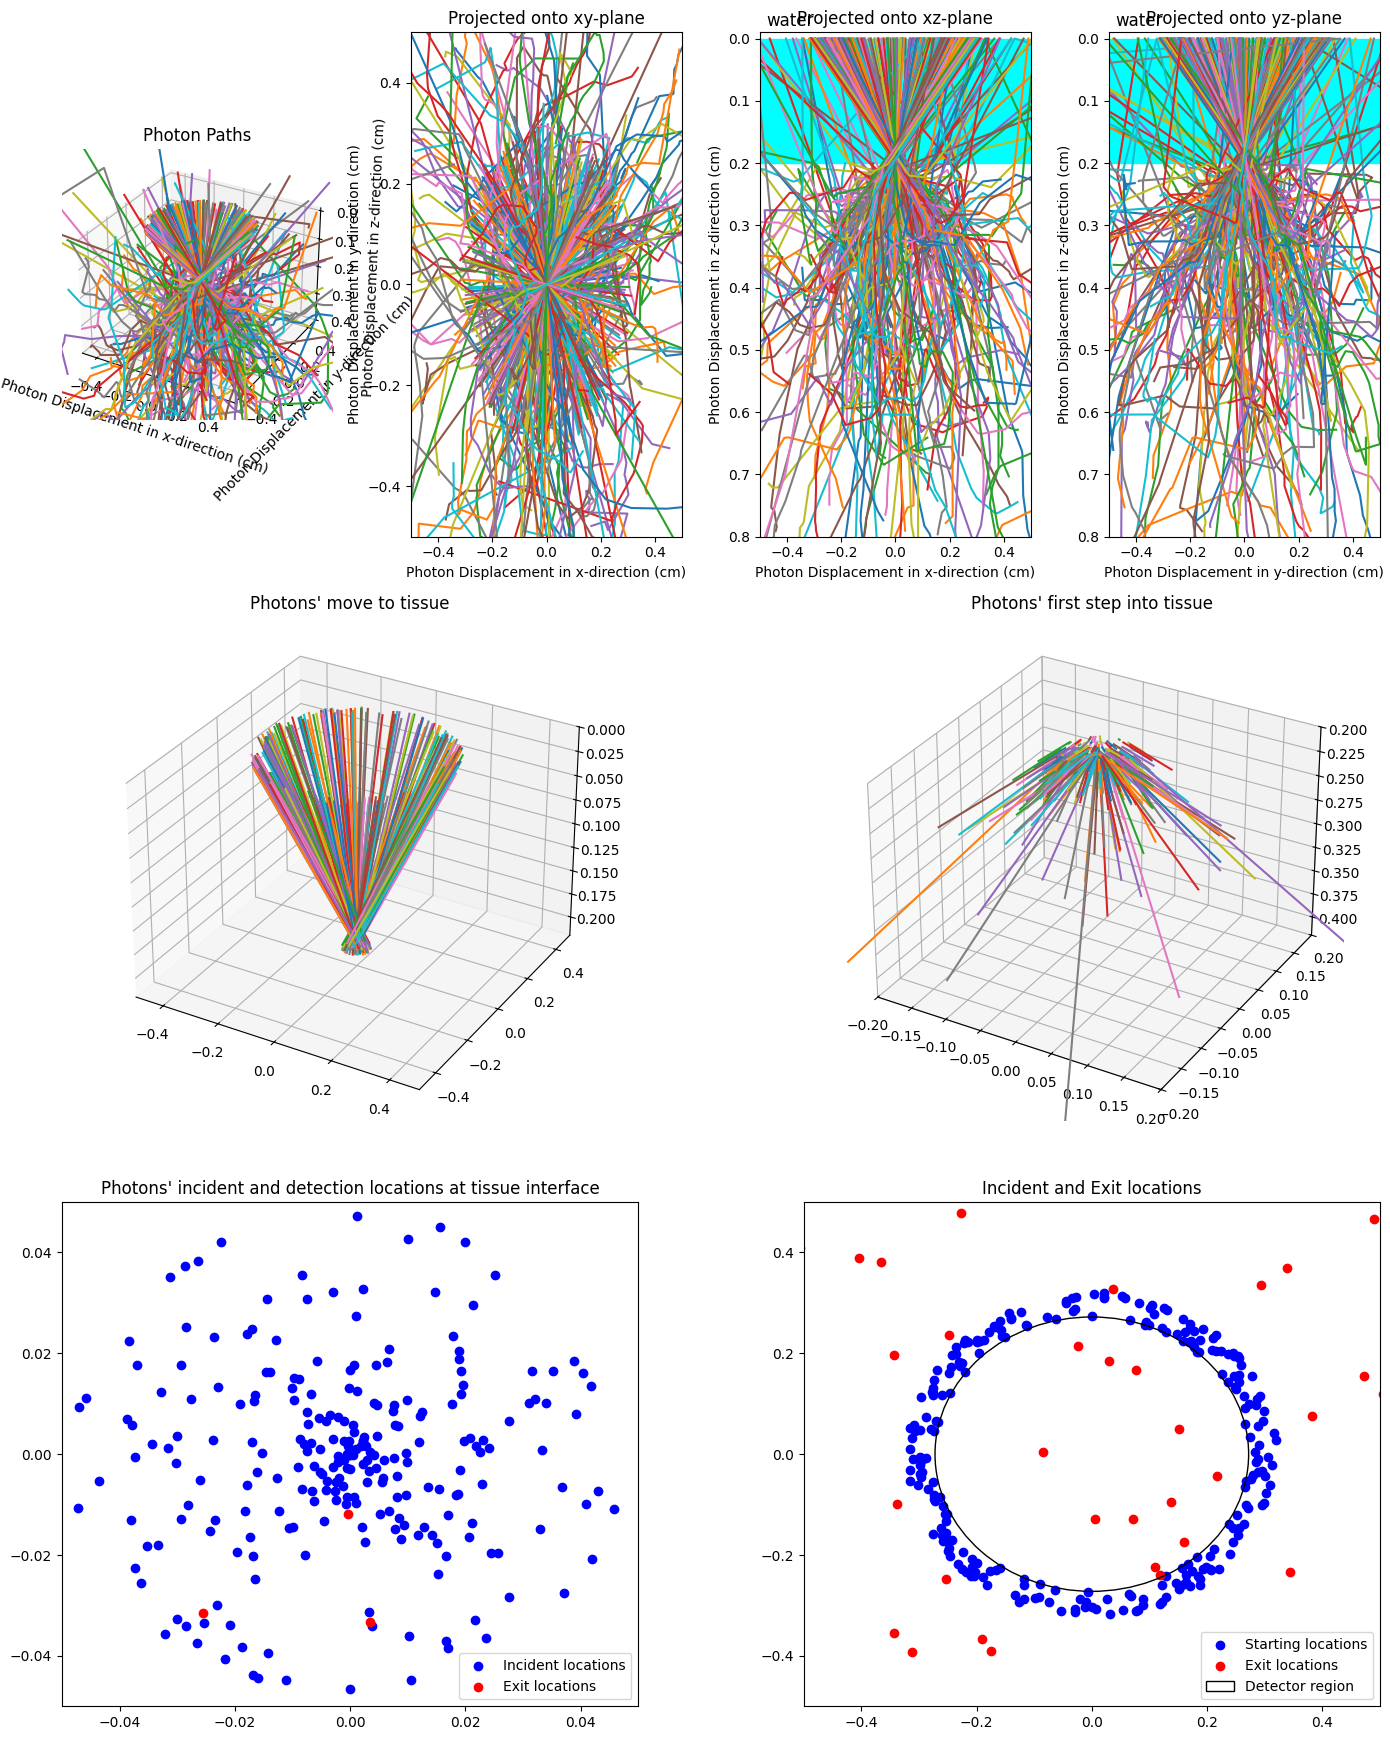

In [43]:
detector.reset()
photon = s.beam(n=n, recurse=False, russian_roulette_constant=20, tir_limit=100)
photon.simulate()
make_all_plots(photon, tissue_start=0.2, into_tissue_step=1)

## Simulation 8
Using system with water and glass

In [44]:
s = mc.System(
    dw, 0.2,
    g, 0.017,
    t, float('inf'),
    surrounding_n=surroundings_n,
    illuminator=LED,
    detector=(detector,0)
)
print(s)

 __________________ 
|------ -inf ------|
|-> Surroundings <-|
|------- 0 --------|
|->    Water     <-|
|------ 0.2 -------|
|->    Glass     <-|
|----- 0.217 ------|
|->    Tissue    <-|
|------ inf -------|
 __________________ 


0 total internal reflectance events.
0.95% of photons transmitted. 
9.40% of photons reflected 
89.57% of photons absorbed 
250 total photons simulated.
23.16 photons rejected by detector aperture.
0.15% of photons detected 
0.08% overage of photons.


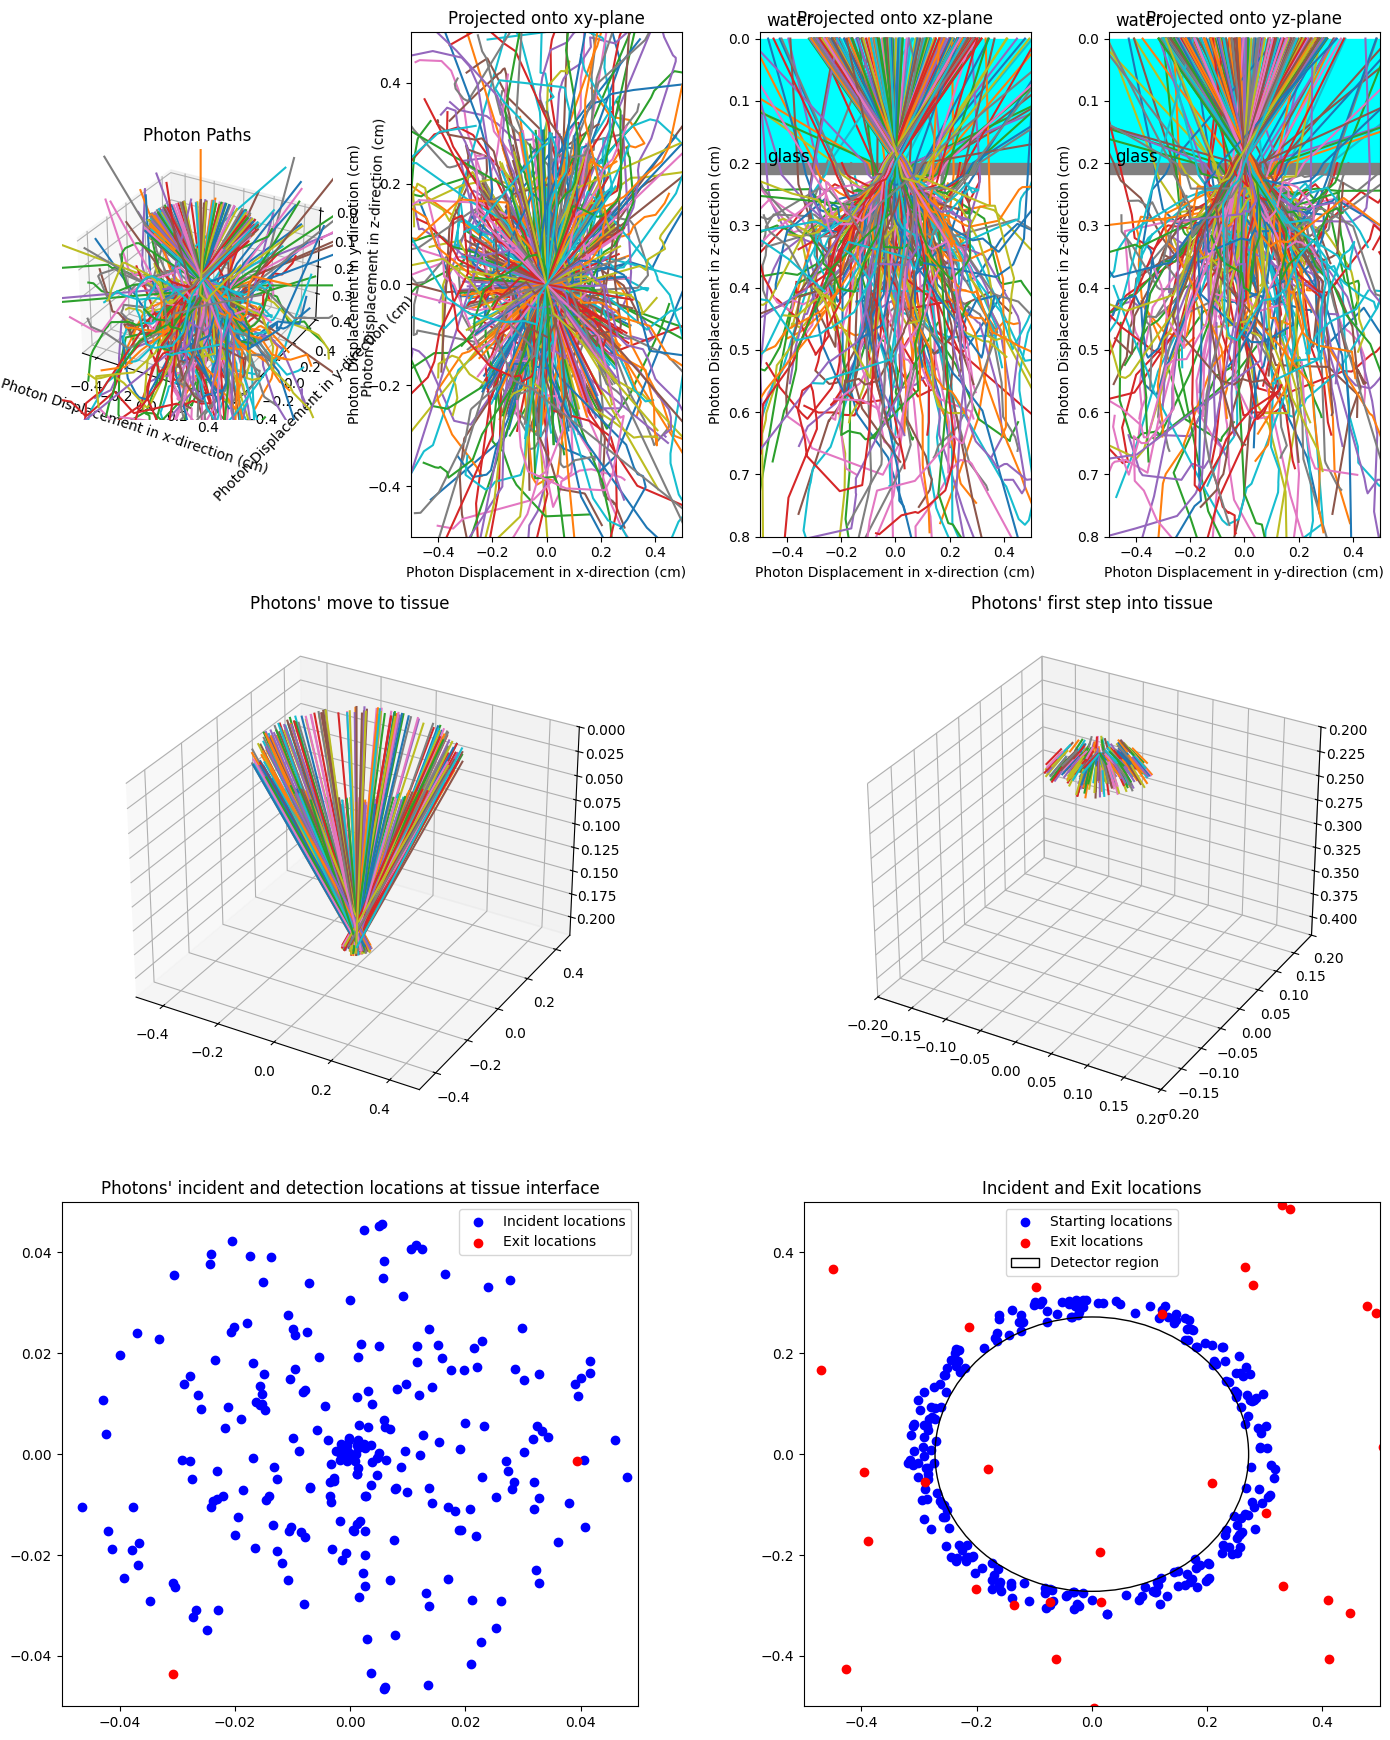

In [45]:
detector.reset()
photon = s.beam(n=n, recurse=False, russian_roulette_constant=20, tir_limit=100)
photon.simulate()
make_all_plots(photon, tissue_start=0.2 + 0.017, into_tissue_step=2)

## Simulation 9
Finite tissue layer

In [46]:
s = mc.System(
    dw, 0.2,
    g, 0.017,
    t, 0.1,
    surrounding_n=surroundings_n,
    illuminator=LED,
    detector=(detector, 0)
)
print(s)

 __________________ 
|------ -inf ------|
|-> Surroundings <-|
|------- 0 --------|
|->    Water     <-|
|------ 0.2 -------|
|->    Glass     <-|
|----- 0.217 ------|
|->    Tissue    <-|
|----- 0.317 ------|
|-> Surroundings <-|
|------ inf -------|
 __________________ 


0 total internal reflectance events.
18.53% of photons transmitted. 
10.04% of photons reflected 
71.43% of photons absorbed 
250 total photons simulated.
15.60 photons rejected by detector aperture.
4.05% of photons detected 
0.00% overage of photons.


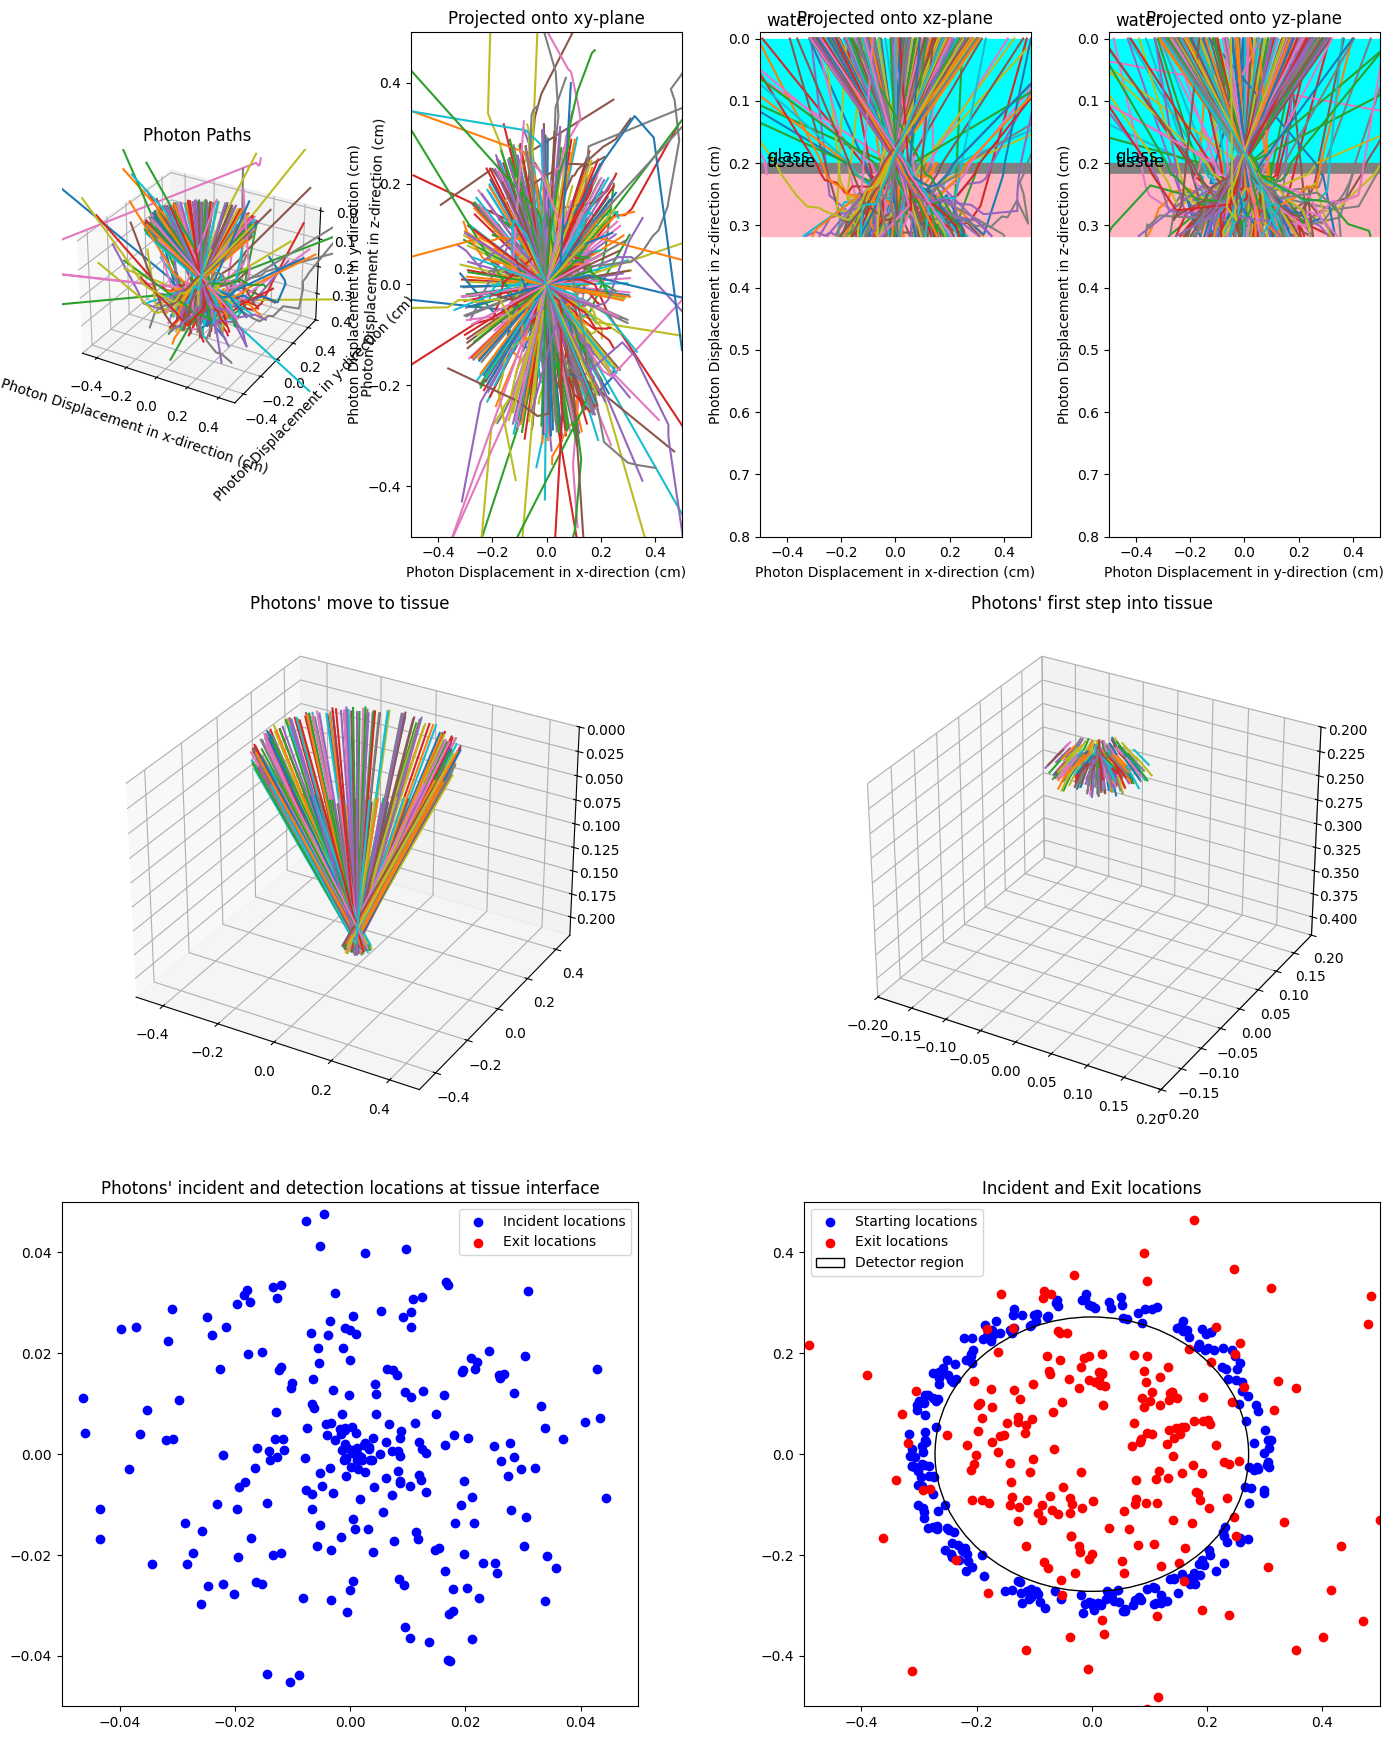

In [47]:
detector.reset()
photon = s.beam(n=n, recurse=False, russian_roulette_constant=20, tir_limit=100)
photon.simulate()
make_all_plots(photon)